## Unnormalized

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import os
import alphashape
from scipy.spatial import KDTree


calculation_alpha_parameter = 1.3
distance_threshold = 0.5

def calculate_periphery(x, y, lengths, orientations, alpha):
    """Calculate the concave hull of the colony using the rod positions."""
    rod_endpoints = []
    for xi, yi, length, orientation in zip(x, y, lengths, orientations):
        dx = (length / 2) * np.cos(orientation)
        dy = (length / 2) * np.sin(orientation)
        rod_endpoints.extend([(xi - dx, yi - dy), (xi + dx, yi + dy)])
    rod_endpoints = np.array(rod_endpoints)
    hull = alphashape.alphashape(rod_endpoints, alpha)
    return hull

def generate_points_along_rod(xi, yi, length, orientation, num_points=10):
    """Generate points along a rod to check proximity to the hull."""
    dx = (length / 2) * np.cos(orientation)
    dy = (length / 2) * np.sin(orientation)
    points = np.linspace(0, 1, num_points)
    return [(xi - dx + 2 * dx * t, yi - dy + 2 * dy * t) for t in points]

def count_periphery_cells(x, y, lengths, orientations, color2, hull, com_x, com_y, distance_threshold):
    """Count how many cells of each aspect ratio are on the periphery."""
    hull_points = np.array(hull.exterior.xy).T
    kdtree = KDTree(hull_points)
    periphery_count_asp1, periphery_count_asp2 = 0, 0

    for xi, yi, length, orientation, col2 in zip(x, y, lengths, orientations, color2):
        rod_points = generate_points_along_rod(xi, yi, length, orientation)
        for point in rod_points:
            distance_to_hull, _ = kdtree.query(point)
            if distance_to_hull <= distance_threshold:
                if col2 == 0:
                    periphery_count_asp1 += 1
                else:
                    periphery_count_asp2 += 1
                break  

    return periphery_count_asp1, periphery_count_asp2


results_per_aspect_ratio = {}
thickness = 0.1
max_length = 0


for trial in range(1, 6):
    trial_path = f"/home/mratman1/activeMatterCommunities/workspace/experiments/equal_gr_v1/asp10/run{trial}"
    subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

    for subfolder in subfolders:
        csv_files = sorted(
    [f for f in os.listdir(subfolder) if f.endswith('.csv') and f.strip('.csv').isdigit()],
    key=lambda f: int(f.strip('.csv'))
)
        if not csv_files:
            continue

        output1_temp, output2_temp = [], []

        for time_file in csv_files:
            time = int(time_file.strip('.csv'))
            df = pd.read_csv(f"{subfolder}/{time_file}")
            x, y, ex, ey, lengths, color2 = df[["x", "y", "ex", "ey", "l", "color2"]].T.values
            orientations = np.arctan2(ey, ex)

            
            com_x, com_y = np.mean(x), np.mean(y)
            distances = np.sqrt((x - com_x) ** 2 + (y - com_y) ** 2)
            radius = np.max(distances)

            
            hull = calculate_periphery(x, y, lengths, orientations, alpha=calculation_alpha_parameter)

            
            periphery_count_asp1, periphery_count_asp2 = count_periphery_cells(
                x, y, lengths, orientations, color2, hull, com_x, com_y, distance_threshold
            )

            
            total_cells = periphery_count_asp1 + periphery_count_asp2
            periphery_fraction_asp1 = periphery_count_asp1 / total_cells
            periphery_fraction_asp2 = periphery_count_asp2 / total_cells

            output1_temp.append(periphery_fraction_asp1)
            output2_temp.append(periphery_fraction_asp2)

        max_length = max(max_length, len(output1_temp))
        asp1 = round(np.max(lengths[color2 == 0]) / thickness, 0)
        asp2 = round(np.max(lengths[color2 == 1]) / thickness, 0)

        if asp1 == 10.0: 
            output1 = output1_temp + [0] * (max_length - len(output1_temp))
            output2 = output2_temp + [0] * (max_length - len(output2_temp))
            aspect_ratio_key = (asp1, asp2)
        else:
            output1 = output2_temp + [0] * (max_length - len(output2_temp))
            output2 = output1_temp + [0] * (max_length - len(output1_temp))
            aspect_ratio_key = (asp2, asp1)
        

        


        if aspect_ratio_key not in results_per_aspect_ratio:
            results_per_aspect_ratio[aspect_ratio_key] = {
                "output1": [], "output2": [], "times": []
            }

        results_per_aspect_ratio[aspect_ratio_key]["output1"].append(output1)
        results_per_aspect_ratio[aspect_ratio_key]["output2"].append(output2)
        results_per_aspect_ratio[aspect_ratio_key]["times"].append([int(f.strip('.csv')) for f in csv_files])


averaged_results = {}
for key, data in results_per_aspect_ratio.items():
    all_times = sorted(set(time for trial_times in data["times"] for time in trial_times))
    avg_output1, sem_output1 = [], []

    for time in all_times:
        trial_outputs = [data["output1"][trial_idx][data["times"][trial_idx].index(time)]
                         for trial_idx, trial_times in enumerate(data["times"]) if time in trial_times]
        avg_output1.append(np.mean(trial_outputs))
        sem_output1.append(np.std(trial_outputs) / np.sqrt(len(trial_outputs)))

    averaged_results[key] = {"avg_output1": avg_output1, "sem_output1": sem_output1, "times": all_times}



sorted_aspects = dict(sorted(averaged_results.items(), key=lambda x: x[0]))
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=2, vmax=10)

fig, ax = plt.subplots(figsize=(12, 7), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for (asp1, asp2), data in sorted_aspects.items():
    times = np.array(data["times"]) / 3e5
    avg_output1, sem_output1 = data["avg_output1"], data["sem_output1"]
    color = 'black' if (asp1, asp2) == (10, 10) else cmap(norm(asp2))
    linewidth = 3 if (asp1, asp2) == (10, 10) else 1

    ax.fill_between(times, np.array(avg_output1) - np.array(sem_output1), np.array(avg_output1) + np.array(sem_output1),
                    color=color, alpha=0.3)
    ax.plot(times, avg_output1, '-', color=color, linewidth=linewidth)


ax.axhline(1, color='black', linestyle='--', linewidth=1.2)
ax.axhline(0.5, color='lime', linestyle='--', linewidth=1.2)


ax.set_xlabel(r"Time ($t/T$)", fontsize=16)
ax.set_ylabel(r"Fraction of $a=10$ Cells at Colony Periphery", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim(0, 1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Population B Aspect Ratio', fontsize=18)
cbar.set_ticks(range(2, 11))
cbar.ax.tick_params(labelsize=16)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.savefig("GRAPH_EQUALGR_AVERAGE.png", bbox_inches='tight', dpi=300)
plt.show()


csv_data = []
for (asp1, asp2), data in averaged_results.items():
    for t, avg, sem in zip(data['times'], data['avg_output1'], data['sem_output1']):
        csv_data.append([asp1, asp2, t, avg, sem])

df_csv = pd.DataFrame(csv_data, columns=['Aspect Ratio 1', 'Aspect Ratio 2', 'Time', 'Avg Output1', 'SEM Output1'])
df_csv.to_csv('equal_gr_periphery_results.csv', index=False)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


csv_file = 'equal_gr_periphery_results.csv'
df = pd.read_csv(csv_file)


combined_data = []
for (asp1, asp2), group_data in df.groupby(['Aspect Ratio 1', 'Aspect Ratio 2']):
    if asp1 == 2 and 9 <= asp2 < 10:
        
        asp1, asp2 = 10, 2
    
    combined_data.append(group_data.assign(Aspect_Ratio_1=asp1, Aspect_Ratio_2=asp2))


df_combined = pd.concat(combined_data)


averaged_data = df_combined.groupby(['Aspect Ratio 1', 'Aspect Ratio 2', 'Time']).agg({
    'Avg Output1': 'mean',
    'SEM Output1': 'mean'  
}).reset_index()


cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=2, vmax=10)


fig, ax = plt.subplots(figsize=(12, 7), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


for (asp1, asp2), group_data in averaged_data.groupby(['Aspect Ratio 1', 'Aspect Ratio 2']):
    
    group_data = group_data.iloc[:-1]

    
    time_scaling_factor = (asp2 / 10) * 3e5
    times = group_data['Time'] / ((((0.5*asp2*0.1)/(3*10**(-5))/0.005)/(10**5))*10**5)
    
    avg_output1 = group_data['Avg Output1']
    sem_output1 = group_data['SEM Output1']
    
    
    color = cmap(norm(asp2))
    linewidth = 3 if (asp1, asp2) == (10, 10) else 1

    
    ax.fill_between(times, avg_output1 - sem_output1, avg_output1 + sem_output1, color=color, alpha=0.3)
    ax.plot(times, avg_output1, '-', color=color, linewidth=linewidth)


ax.axhline(1, color='black', linestyle='--', linewidth=1.2)
ax.axhline(0.5, color='black', linestyle='--', linewidth=1.2)


ax.set_xlabel(r"Time ($t/T$)", fontsize=16)
ax.set_ylabel(r"Fraction of $a=10$ Cells at Colony Periphery", fontsize=16)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylim(0, 1.0)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Population B Aspect Ratio', fontsize=18)
cbar.set_ticks(range(2, 11))
cbar.ax.tick_params(labelsize=20)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.savefig("GRAPH_FROM_CSV_WITH_COMBINED_TRIALS.png", bbox_inches='tight', dpi=300)
plt.show()


## Normalized

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


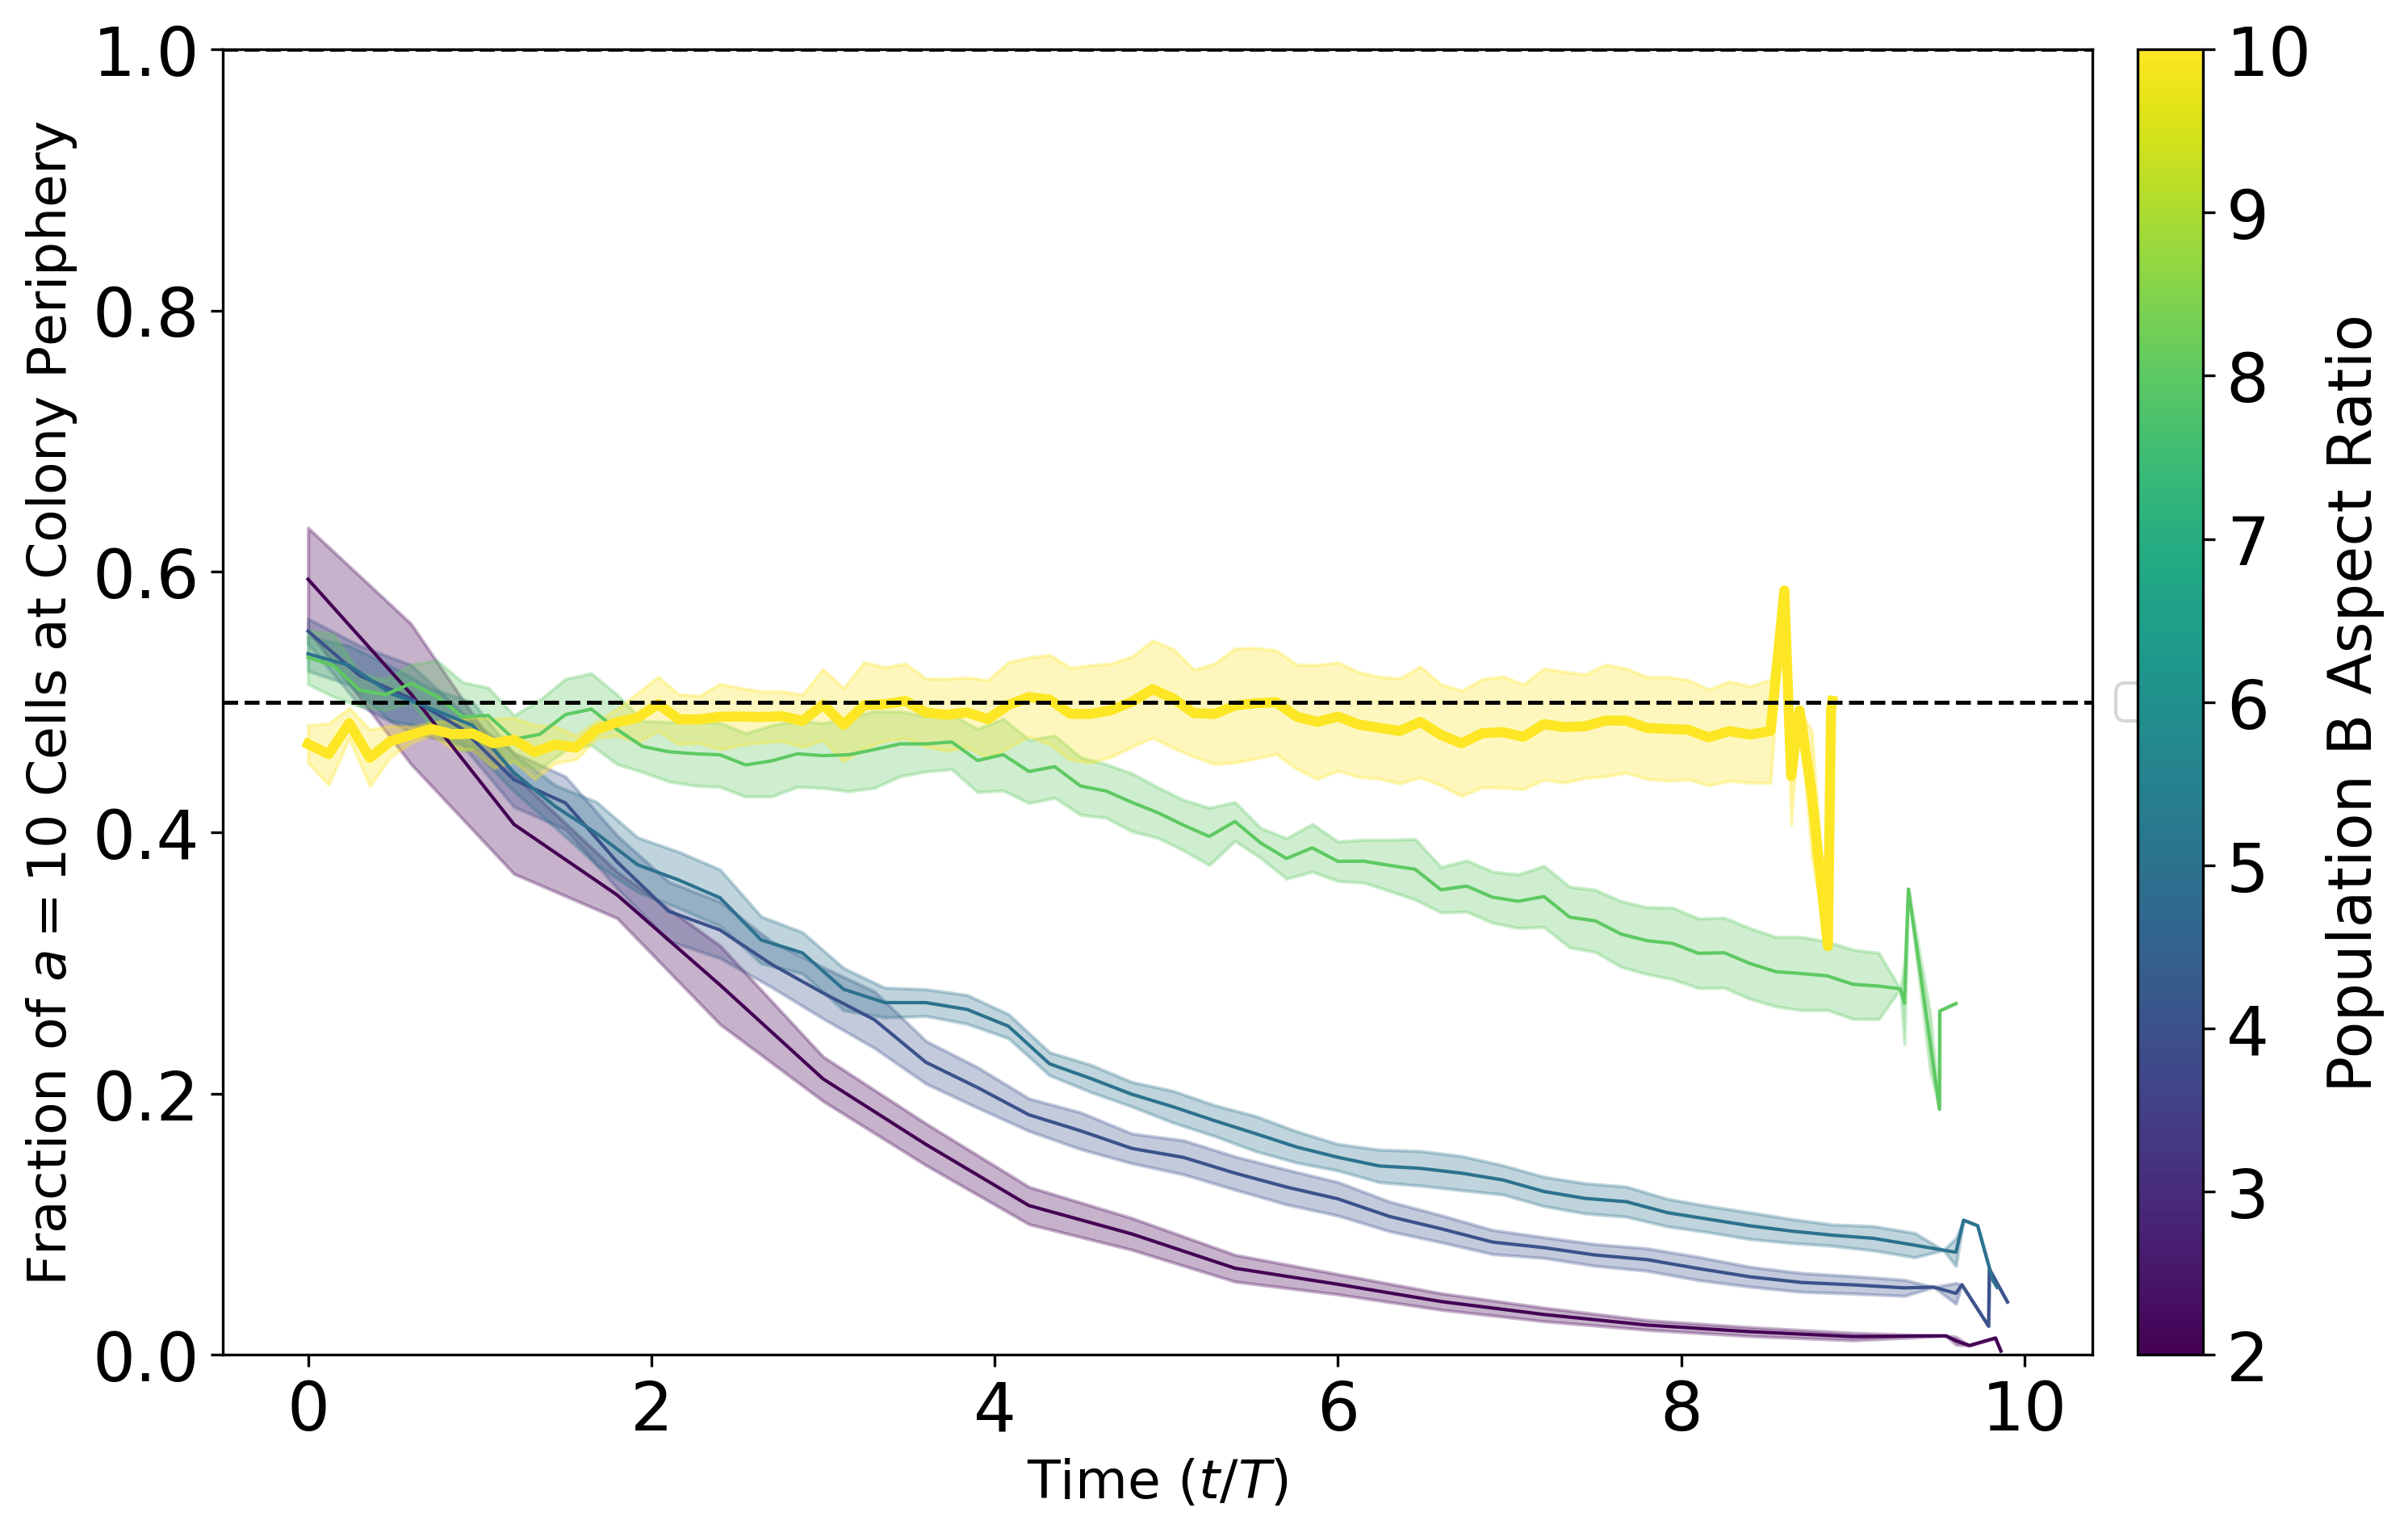

In [8]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import os
import alphashape
from scipy.spatial import KDTree


calculation_alpha_parameter = 1.3
distance_threshold = 0.5

def calculate_periphery(x, y, lengths, orientations, alpha):
    """Calculate the concave hull of the colony using the rod positions."""
    rod_endpoints = []
    for xi, yi, length, orientation in zip(x, y, lengths, orientations):
        dx = (length / 2) * np.cos(orientation)
        dy = (length / 2) * np.sin(orientation)
        rod_endpoints.extend([(xi - dx, yi - dy), (xi + dx, yi + dy)])
    rod_endpoints = np.array(rod_endpoints)
    hull = alphashape.alphashape(rod_endpoints, alpha)
    return hull

def generate_points_along_rod(xi, yi, length, orientation, num_points=10):
    """Generate points along a rod to check proximity to the hull."""
    dx = (length / 2) * np.cos(orientation)
    dy = (length / 2) * np.sin(orientation)
    points = np.linspace(0, 1, num_points)
    return [(xi - dx + 2 * dx * t, yi - dy + 2 * dy * t) for t in points]

def count_periphery_cells(x, y, lengths, orientations, color2, hull, com_x, com_y, distance_threshold):
    """Count how many cells of each aspect ratio are on the periphery."""
    hull_points = np.array(hull.exterior.xy).T
    kdtree = KDTree(hull_points)
    periphery_count_asp1, periphery_count_asp2 = 0, 0

    for xi, yi, length, orientation, col2 in zip(x, y, lengths, orientations, color2):
        rod_points = generate_points_along_rod(xi, yi, length, orientation)
        for point in rod_points:
            distance_to_hull, _ = kdtree.query(point)
            if distance_to_hull <= distance_threshold:
                if col2 == 0:
                    periphery_count_asp1 += 1
                else:
                    periphery_count_asp2 += 1
                break  

    return periphery_count_asp1, periphery_count_asp2


results_per_aspect_ratio = {}
thickness = 0.1
max_length = 0


for trial in range(1, 6):
    trial_path = f"/home/mratman1/activeMatterCommunities/workspace/experiments/equal_gr_v1/asp10/run{trial}"
    subfolders = [f.path for f in os.scandir(trial_path) if f.is_dir()]

    for subfolder in subfolders:
        csv_files = sorted(
    [f for f in os.listdir(subfolder) if f.endswith('.csv') and f.strip('.csv').isdigit()],
    key=lambda f: int(f.strip('.csv'))
)
        if not csv_files:
            continue

        output1_temp, output2_temp = [], []

        for time_file in csv_files:
            time = int(time_file.strip('.csv'))
            df = pd.read_csv(f"{subfolder}/{time_file}")
            x, y, ex, ey, lengths, color2 = df[["x", "y", "ex", "ey", "l", "color2"]].T.values
            orientations = np.arctan2(ey, ex)

            
            com_x, com_y = np.mean(x), np.mean(y)
            distances = np.sqrt((x - com_x) ** 2 + (y - com_y) ** 2)
            radius = np.max(distances)
            asp1_total_cell_num = 0
            asp2_total_cell_num = 0
            for i in range(len(x)):
                if color2[i] == 0:
                    asp1_total_cell_num += 1
                else:
                    asp2_total_cell_num += 1
            
            hull = calculate_periphery(x, y, lengths, orientations, alpha=calculation_alpha_parameter)

            
            periphery_count_asp1, periphery_count_asp2 = count_periphery_cells(
                x, y, lengths, orientations, color2, hull, com_x, com_y, distance_threshold
            )

            
            total_cells = periphery_count_asp1 + periphery_count_asp2
            periphery_fraction_asp1 = periphery_count_asp1 / total_cells
            periphery_fraction_asp2 = periphery_count_asp2 / total_cells
            
            normalized1 = periphery_count_asp1/asp1_total_cell_num - periphery_count_asp2/asp2_total_cell_num
            normalized2 = -1*(periphery_count_asp1/asp1_total_cell_num - periphery_count_asp2/asp2_total_cell_num)
            
            
            
            output1_temp.append(normalized1)
            output2_temp.append(normalized2)

        max_length = max(max_length, len(output1_temp))
        asp1 = round(np.max(lengths[color2 == 0]) / thickness, 0)
        asp2 = round(np.max(lengths[color2 == 1]) / thickness, 0)

        if asp1 == 10: 
            output1 = output1_temp + [0] * (max_length - len(output1_temp))
            output2 = output2_temp + [0] * (max_length - len(output2_temp))
            aspect_ratio_key = (asp1, asp2)
        else:
            output1 = output2_temp + [0] * (max_length - len(output2_temp))
            output2 = output1_temp + [0] * (max_length - len(output1_temp))
            aspect_ratio_key = (asp2, asp1)
        
        

        


        if aspect_ratio_key not in results_per_aspect_ratio:
            results_per_aspect_ratio[aspect_ratio_key] = {
                "output1": [], "output2": [], "times": []
            }

        results_per_aspect_ratio[aspect_ratio_key]["output1"].append(output1)
        results_per_aspect_ratio[aspect_ratio_key]["output2"].append(output2)
        results_per_aspect_ratio[aspect_ratio_key]["times"].append([int(f.strip('.csv')) for f in csv_files])

    print(f'done trial {trial}')

averaged_results = {}
for key, data in results_per_aspect_ratio.items():
    all_times = sorted(set(time for trial_times in data["times"] for time in trial_times))
    avg_output1, sem_output1 = [], []

    for time in all_times:
        trial_outputs = [data["output1"][trial_idx][data["times"][trial_idx].index(time)]
                         for trial_idx, trial_times in enumerate(data["times"]) if time in trial_times]
        avg_output1.append(np.mean(trial_outputs))
        sem_output1.append(np.std(trial_outputs) / np.sqrt(len(trial_outputs)))

    averaged_results[key] = {"avg_output1": avg_output1, "sem_output1": sem_output1, "times": all_times}



sorted_aspects = dict(sorted(averaged_results.items(), key=lambda x: x[0]))
cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=2, vmax=10)

fig, ax = plt.subplots(figsize=(12, 7), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')

for (asp1, asp2), data in sorted_aspects.items():
    times = np.array(data["times"]) / 3e5
    avg_output1, sem_output1 = data["avg_output1"], data["sem_output1"]
    color = cmap(norm(asp2))
    linewidth = 3 if (asp1, asp2) == (10, 10) else 1

    ax.fill_between(times, np.array(avg_output1) - np.array(sem_output1), np.array(avg_output1) + np.array(sem_output1),
                    color=color, alpha=0.3)
    ax.plot(times, avg_output1, '-', color=color, linewidth=linewidth)


ax.axhline(1, color='black', linestyle='--', linewidth=1.2)
ax.axhline(0.5, color='lime', linestyle='--', linewidth=1.2)


ax.set_xlabel(r"Time ($t/T$)", fontsize=16)
ax.set_ylabel(r"Fraction of $a=10$ Cells at Colony Periphery", fontsize=16)
ax.tick_params(axis='both', labelsize=16)
ax.set_ylim(0, 1.0)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Population B Aspect Ratio', fontsize=18)
cbar.set_ticks(range(2, 11))
cbar.ax.tick_params(labelsize=16)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.savefig("GRAPH_EQUALGR_AVERAGE.png", bbox_inches='tight', dpi=300)
plt.show()


csv_data = []
for (asp1, asp2), data in averaged_results.items():
    for t, avg, sem in zip(data['times'], data['avg_output1'], data['sem_output1']):
        csv_data.append([asp1, asp2, t, avg, sem])

df_csv = pd.DataFrame(csv_data, columns=['Aspect Ratio 1', 'Aspect Ratio 2', 'Time', 'Avg Output1', 'SEM Output1'])
df_csv.to_csv('equal_gr_periphery_results_normalized_1.3.csv', index=False)



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors


csv_file = 'equal_gr_periphery_results_normalized_1.3.csv'
df = pd.read_csv(csv_file)


combined_data = []
for (asp1, asp2), group_data in df.groupby(['Aspect Ratio 1', 'Aspect Ratio 2']):
    if asp1 == 2 and 9 <= asp2 < 10:
        
        asp1, asp2 = 10, 2
    
    combined_data.append(group_data.assign(Aspect_Ratio_1=asp1, Aspect_Ratio_2=asp2))


df_combined = pd.concat(combined_data)


averaged_data = df_combined.groupby(['Aspect Ratio 1', 'Aspect Ratio 2', 'Time']).agg({
    'Avg Output1': 'mean',
    'SEM Output1': 'mean'  
}).reset_index()


cmap = plt.get_cmap('viridis')
norm = mcolors.Normalize(vmin=2, vmax=10)


fig, ax = plt.subplots(figsize=(12, 7), dpi=300)
fig.patch.set_facecolor('white')
ax.set_facecolor('white')


for (asp1, asp2), group_data in averaged_data.groupby(['Aspect Ratio 1', 'Aspect Ratio 2']):
    
    group_data = group_data.iloc[:-1]

    
    
    times = group_data['Time'] / ((((0.5*asp2*0.1)/(3*10**(-5))/0.005)/(10**5))*10**5)
    avg_output1 = group_data['Avg Output1']
    sem_output1 = group_data['SEM Output1']
    
    
    color = cmap(norm(asp2))
    linewidth = 3 if (asp1, asp2) == (10, 10) else 1

    
    ax.fill_between(times, avg_output1 - sem_output1, avg_output1 + sem_output1, color=color, alpha=0.3)
    ax.plot(times, avg_output1, '-', color=color, linewidth=linewidth)


ax.axhline(1, color='black', linestyle='--', linewidth=1.2)
ax.axhline(0.0, color='black', linestyle='--', linewidth=1.2)


ax.set_xlabel(r"Time ($t/T$)", fontsize=16)
ax.set_ylabel(r"Fraction of $a=10$ Cells at Colony Periphery", fontsize=16)
ax.tick_params(axis='both', labelsize=20)
ax.set_ylim(-0.2, 0.4)


sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
cbar.set_label('Population B Aspect Ratio', fontsize=18)
cbar.set_ticks(range(2, 11))
cbar.ax.tick_params(labelsize=20)


plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.savefig("GRAPH_FROM_CSV_WITH_COMBINED_TRIALS.png", bbox_inches='tight', dpi=300)
plt.show()
